## 5.3 Isolation Forest    
Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.  


- Isolation Forest   
Ad: 
  - It needs small samples from large datasets so as to derive an anomaly detection function which makes it fast and
scalable.
  - It does not require example anomalies in the training dataset. 
  - The tree depth is the basis of its distance threshold for determining anomalies which is autonomous from the scaling of the dataset dimensions. 
  - It can both work as a supervised and an unsupervised classifier and its objective is that the anomalies are less recurrent than usual observations and vary from their values. 




reference : http://pen.ius.edu.ba/index.php/pen/article/view/533/312
#### Acknowledgement
https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
    

**Default values are**   

class sklearn.ensemble.IsolationForest(*, 
- n_estimators=100, 
- max_samples='auto',  max_samples=min(256, n_samples) for auto
- contamination='auto', 
- max_features=1.0, 
- bootstrap=False, 
- n_jobs=None, 
- behaviour='deprecated', 
- random_state=None, 
- verbose=0, 
- warm_start=False)

We train for different number of estimators


In [17]:
# importing the packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import sklearn.exceptions
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss 
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,accuracy_score
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


from numpy import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
data_train = pd.read_csv("fraudTrain.csv")
data_test = pd.read_csv("fraudTest.csv")
# taking smaller sample to run the model faster

df_train= data_train.sample(frac = 0.1,random_state=1)
df_test= data_test.sample(frac = 0.05,random_state=1)
print(df_train.shape,df_test.shape)

(129668, 23) (27786, 23)


In [3]:
def getdatafiles():
    # loading data
    data_train = pd.read_csv("fraudTrain.csv")
    data_test = pd.read_csv("fraudTest.csv")
    # taking smaller sample to run the model faster

    df_train= data_train.sample(frac = 0.1,random_state=1)
    df_test= data_test.sample(frac = 0.05,random_state=1)
    print(df_train.shape,df_test.shape)
    
    # function to drop tbe columns
    def dropCol(data):
        col_to_drop = ['trans_date_trans_time','Unnamed: 0',
                       'cc_num','first','last','trans_num','street',
                      'trans_date_trans_time','unix_time']
        res = data.drop(col_to_drop,axis = 1)
        return res
    # dropping the columns
    # dropping the columns ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num']
    # train data set
    df_train = dropCol(df_train)
    # test data set
    df_test = dropCol(df_test)
    
    # creating a new feature address
    df_train['add'] = df_train['city'] + df_train['state'] + df_train['zip'].astype(str)
    df_test['add'] = df_test['city'] + df_test['state'] + df_test['zip'].astype(str)
    df_train = df_train.drop(['city','state','zip'],axis =1)
    df_test = df_test.drop(['city','state','zip'],axis =1)
    print ( df_train.shape, df_test.shape)
    

    #Create independent and Dependent Features
    columns = df_train.columns.tolist()

    # removing the dependent feature is_fraud
    columns = [c for c in columns if c not in ["is_fraud"]]

    X_train = df_train[columns]
    Y_train = df_train['is_fraud']
    X_test = df_test[columns]
    Y_test = df_test['is_fraud']
    print ( X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

    # function to convert dob to years
    def age_years(born):
        return 2019 - int(born[0:4])

    # replacing the dob column with age column in our data set for test and train
    X_train['age'] = X_train['dob'].apply(lambda x: age_years(x))
    X_train = X_train.drop(['dob'],axis =1)

    X_test['age'] = X_test['dob'].apply(lambda x: age_years(x))
    X_test = X_test.drop(['dob'],axis =1)
    
    print(X_train.shape,X_test.shape)

    # concanating the test and train data so that number of columns remain the same in both the data sets
    final_df = pd.concat([X_train,X_test],axis=0)
    final_df.shape


    # creating the list of categorical variables
    categorical_features =[feature for feature in X_train.columns if final_df[feature].dtypes == 'O']
    categorical_features
    
    # function to convert categorical variables to one hot encoding
    def category_onehot_multcols(data,multcolumns):
        df_final = data
        i=0
        for fields in multcolumns:
            print(fields)
            df1=pd.get_dummies(final_df[fields],drop_first=True)
            final_df.drop([fields],axis=1,inplace=True)
            if i==0:
                df_final=df1.copy()
            else:           
                df_final=pd.concat([df_final,df1],axis=1)
            i=i+1             
        df_final=pd.concat([final_df,df_final],axis=1)
        return df_final

    # applying the one hot encoding
    final_df = category_onehot_multcols(final_df, categorical_features)

    # removing duplicated columns
    final_df =final_df.loc[:,~final_df.columns.duplicated()]
    final_df.shape

    # separating the test and training data
    df_Train=final_df.iloc[:129668,:]
    df_Test=final_df.iloc[129668:,:]
    print(df_Train.shape,df_Test.shape)
    print(Y_train.value_counts(),"\n",Y_test.value_counts())
    
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    df_Train = scaler.fit_transform(df_Train)
    df_Test = scaler.fit_transform(df_Test)# define standard scaler
    
    
    
    # files ready for testing on models
    print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)
    return df_Train, df_Test, Y_train, Y_test


In [4]:
# function to evaluate our model 
def print_eval(y_pred,model):
    print("Training Accuracy: ",model.score(df_Train, Y_train))
    print("Testing Accuracy: ", model.score(df_Test, Y_test))
    print(confusion_matrix(Y_test, y_pred))
    
    print(classification_report(Y_test,y_pred))


In [5]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

(129668, 23) (27786, 23)
(129668, 13) (27786, 13)
(129668, 12) (129668,) (27786, 12) (27786,)
(129668, 12) (27786, 12)
merchant
category
gender
job
add
(129668, 2143) (27786, 2143)
0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64
(129668, 2143) (27786, 2143) (129668,) (27786,)


In [ ]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

In [7]:
## Get the Fraud and the normal  transaction numbers for test and train dataset 

fraud_train = df_train[df_train['is_fraud']==1]
normal_train = df_train[df_train['is_fraud']==0]
fraud_test = df_test[df_test['is_fraud']==1]
normal_test = df_test[df_test['is_fraud']==0]

print("Normal cases in train set :",len(df_train)-len(fraud_train),"\nFraud cases in train set :",len(fraud_train))
print("Normal cases in test set :",len(df_test)-len(fraud_test),"\nFraud cases in test set :",len(fraud_test))
outlier_fraction = round(len(fraud_train)/len(df_train),4)
print("Fraud percentage :", outlier_fraction)
print("Fraud percentage :", len(fraud_test)/len(df_test))

Normal cases in train set : 128963 
Fraud cases in train set : 705
Normal cases in test set : 27656 
Fraud cases in test set : 130
Fraud percentage : 0.0054
Fraud percentage : 0.004678615129921543


### for different number of estimators

In [80]:
%%time
ne = [50,75,80,85,90,95,100,200,500]

outlier_fraction = len(fraud_test)/len(df_Test)
precesion_if_1 = []
recall_if_1 = []
f1score_if_1 = []
roc = []
for n_est in ne:
    model_isolation = IsolationForest(n_estimators = n_est,
                                      max_samples = len(df_Test),
                                      contamination = outlier_fraction,
                                     random_state = 137).fit(df_Test)
    # predictions
    y_pred = model_isolation.predict(df_Test) # Prediction using trained model.
    y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
    y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
    # results 
    errors = (y_pred != Y_test).sum() # Total number of errors is calculated.
    #print(errors_f1)
    #print(accuracy_score(Y_test,y_pred))
    #print(classification_report(Y_test,y_pred))
    #print("roc_auc_score",roc_auc_score(Y_test,y_pred))
    #print(confusion_matrix(Y_test,y_pred))
    prfs = precision_recall_fscore_support(Y_test,y_pred , average=None)
    #res_recall[i] = round(prfs[1][1],2)
    precesion_if_1.append(prfs[0][1])
    
    recall_if_1.append(prfs[1][1])
    
    f1score_if_1.append(prfs[2][1])
    
    roc.append(roc_auc_score(Y_test,y_pred))
    recall_0   = prfs[1][0]
    recall_1   = prfs[1][1]
    prec_0     = prfs[0][0]
    prec_1     = prfs[0][1]
    f1_score_0 = prfs[2][0]
    f1_score_1 = prfs[2][1]
    

CPU times: user 15min 58s, sys: 10min 50s, total: 26min 48s
Wall time: 27min 52s


In [81]:
print(recall_if_1_ne)

[0.007692307692307693, 0.023076923076923078, 0.015384615384615385, 0.0, 0.0, 0.007692307692307693, 0.007692307692307693, 0.0]


Text(0.5, 1.0, 'roc')

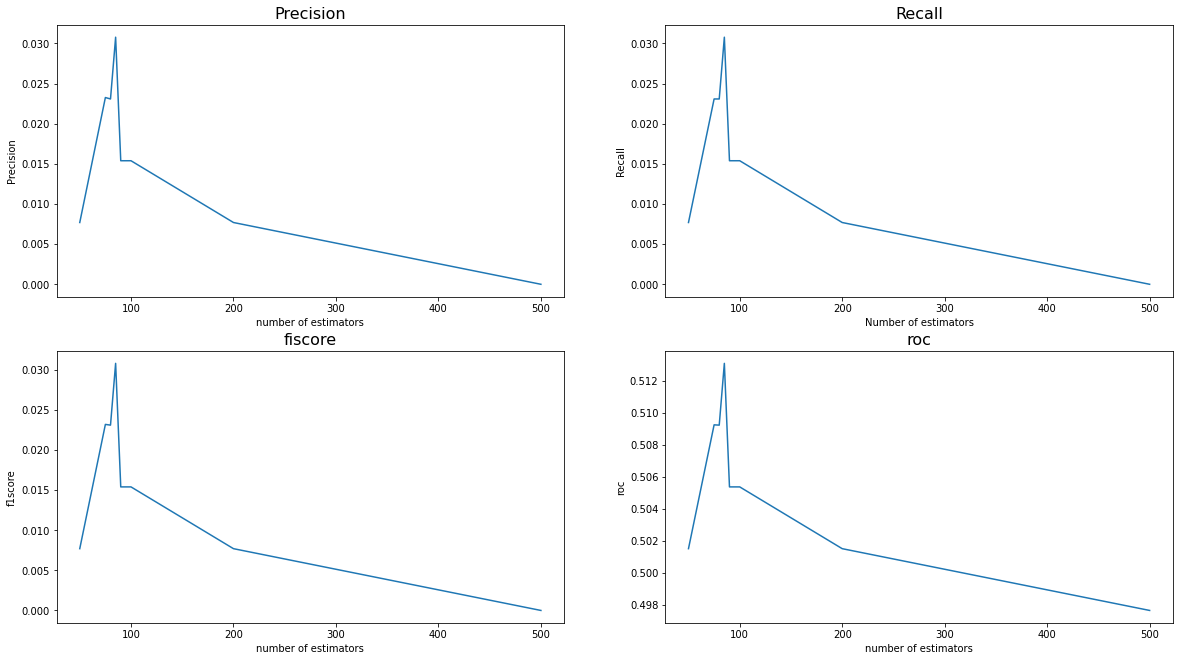

In [82]:
precesion_if_1_ne = precesion_if_1
recall_if_1_ne = recall_if_1
f1score_if_1_ne = f1score_if_1
roc_ne = roc

fig = plt.figure(1,figsize =(20,11) )
plt.subplot(2,2,1)
plt.plot(ne,precesion_if_1_ne)
plt.xlabel('number of estimators')
plt.ylabel('Precision')
plt.title("Precision",fontsize = 16)

plt.subplot(2,2,2)
plt.plot(ne,recall_if_1_ne)
plt.xlabel('Number of estimators')
plt.ylabel('Recall')
plt.title("Recall",fontsize = 16)

plt.subplot(2,2,3)
plt.plot(ne,f1score_if_1_ne)
plt.xlabel('number of estimators')
plt.ylabel('f1score')
plt.title("fiscore",fontsize = 16)

plt.subplot(2,2,4)
plt.plot(ne,roc_ne)
plt.xlabel('number of estimators')
plt.ylabel('roc')
plt.title("roc",fontsize = 16)



In [ ]:
# plotting roc wrt to number of estimators
plt.plot(ne,roc)
plt.xlabel('number of estimators')
plt.ylabel('roc Score')
plt.title("ROC",fontsize = 16)

### We see that 100 is the number of estimators which is giivng the best roc, we try to change the max_sample size.

In [38]:
%%time
ms = [100,200,256,300,400,500,600,700,1000]

outlier_fraction = len(fraud_test)/len(df_Test)
precesion_if_1 = []
recall_if_1 = []
f1score_if_1 = []
roc = []
for max_s in ms:
    model_isolation = IsolationForest(n_estimators = 100,
                                      max_samples = max_s,
                                      contamination = outlier_fraction,
                                     random_state = 137).fit(df_Test)
    # predictions
    y_pred = model_isolation.predict(df_Test) # Prediction using trained model.
    y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
    y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
    # results 
    errors = (y_pred != Y_test).sum() # Total number of errors is calculated.
    #print(errors_f1)
    #print(accuracy_score(Y_test,y_pred))
    #print(classification_report(Y_test,y_pred))
    #print("roc_auc_score",roc_auc_score(Y_test,y_pred))
    #print(confusion_matrix(Y_test,y_pred))
    prfs = precision_recall_fscore_support(Y_test,y_pred , average=None)
    #res_recall[i] = round(prfs[1][1],2)
    precesion_if_1.append(prfs[0][1])
    recall_if_1.append(prfs[1][1])
    f1score_if_1.append(prfs[2][1])
    roc.append(roc_auc_score(Y_test,y_pred))
    recall_0   = prfs[1][0]
    recall_1   = prfs[1][1]
    prec_0     = prfs[0][0]
    prec_1     = prfs[0][1]
    f1_score_0 = prfs[2][0]
    f1_score_1 = prfs[2][1]
    

CPU times: user 6min 5s, sys: 4min 1s, total: 10min 6s
Wall time: 10min 8s


Text(0.5, 1.0, 'ROC')

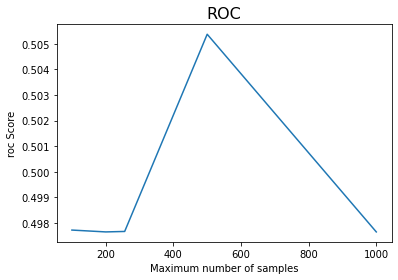

In [39]:
# plotting precision,recall,f1score,roc wrt to number of estimators
precesion_if_1_ms = precesion_if_1
recall_if_1_ms = recall_if_1
f1score_if_1_ms = f1score_if_1
roc_ms = roc

fig = plt.figure(1,figsize =(20,11) )
plt.subplot(2,2,1)
plt.plot(ne,precesion_if_1_ms)
plt.xlabel('Number of max_samples')
plt.ylabel('Precision')
plt.title("Precision",fontsize = 16)

plt.subplot(2,2,2)
plt.plot(ne,recall_if_1_ms)
plt.xlabel('Number of max_samples')
plt.ylabel('Recall')
plt.title("Recall",fontsize = 16)

plt.subplot(2,2,3)
plt.plot(ne,f1score_if_1_ms)
plt.xlabel('number of max_samples')
plt.ylabel('f1score')
plt.title("fiscore",fontsize = 16)

plt.subplot(2,2,4)
plt.plot(ne,roc_ms)
plt.xlabel('number of max_samples')
plt.ylabel('roc')
plt.title("roc",fontsize = 16)

In [42]:
print(recall_if_1)

[0.0, 0.0, 0.0, 0.015384615384615385, 0.0]


### WE choose maximum number of samples as 500, number of estimators as 100 and now we test for contamination

In [44]:
%%time
cn = [.001,.005,.006,.007,.008,.01,.02,.1]

outlier_fraction = len(fraud_test)/len(df_Test)
precesion_if_1 = []
recall_if_1 = []
f1score_if_1 = []
roc = []
for cnr in cn:
    model_isolation = IsolationForest(n_estimators = 100,
                                      max_samples = 500,
                                      contamination = cnr,
                                     random_state = 137).fit(df_Test)
    # predictions
    y_pred = model_isolation.predict(df_Test) # Prediction using trained model.
    y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
    y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
    # results 
    errors = (y_pred != Y_test).sum() # Total number of errors is calculated.
    #print(errors_f1)
    #print(accuracy_score(Y_test,y_pred))
    #print(classification_report(Y_test,y_pred))
    #print("roc_auc_score",roc_auc_score(Y_test,y_pred))
    #print(confusion_matrix(Y_test,y_pred))
    prfs = precision_recall_fscore_support(Y_test,y_pred , average=None)
    #res_recall[i] = round(prfs[1][1],2)
    precesion_if_1.append(prfs[0][1])
    recall_if_1.append(prfs[1][1])
    f1score_if_1.append(prfs[2][1])
    roc.append(roc_auc_score(Y_test,y_pred))
    recall_0   = prfs[1][0]
    recall_1   = prfs[1][1]
    prec_0     = prfs[0][0]
    prec_1     = prfs[0][1]
    f1_score_0 = prfs[2][0]
    f1_score_1 = prfs[2][1]

CPU times: user 9min 46s, sys: 6min 16s, total: 16min 3s
Wall time: 16min 10s


In [55]:
print(f1score_if_1)


[0.0, 0.014869888475836432, 0.0202020202020202, 0.018461538461538463, 0.016997167138810203, 0.014705882352941176, 0.01457725947521866, 0.012375386730835339]


Text(0.5, 1.0, 'ROC plot as per Contamination Rate')

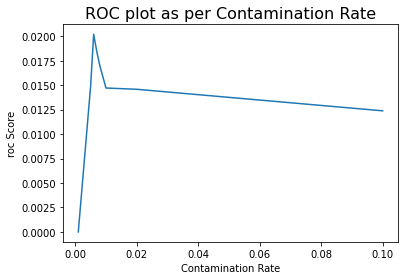

In [58]:
# plotting roc wrt to number of estimators


plt.plot(cn,f1score_if_1)
plt.xlabel('Contamination Rate')
plt.ylabel('roc Score')
plt.title("ROC plot as per Contamination Rate",fontsize = 16)

### We choose maximum number of samples is 500, number of estimators is 100 and contamination ratio is 0.005 which is the actual contamination ration



In [91]:
%%time
# final results without any optimization
model_isolation = IsolationForest(n_estimators = 100,
                                      max_samples = 500,
                                      contamination = outlier_fraction,
                                     random_state = 137).fit(df_Test)
# predictions
y_pred = model_isolation.predict(df_Test) # Prediction using trained model.
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
# results 
errors = (y_pred != Y_test).sum() # Total number of errors is calculated.
#print(errors_f1)
#print(accuracy_score(Y_test,y_pred))
#print(classification_report(Y_test,y_pred))
#print("roc_auc_score",roc_auc_score(Y_test,y_pred))
#print(confusion_matrix(Y_test,y_pred))
prfs = precision_recall_fscore_support(Y_test,y_pred , average=None)
#res_recall[i] = round(prfs[1][1],2)
precesion_if_1.append(prfs[0][1])
recall_if_1.append(prfs[1][1])
f1score_if_1.append(prfs[2][1])
roc.append(roc_auc_score(Y_test,y_pred))
recall_0   = prfs[1][0]
recall_1   = prfs[1][1]
prec_0     = prfs[0][0]
prec_1     = prfs[0][1]
f1_score_0 = prfs[2][0]
f1_score_1 = prfs[2][1]


CPU times: user 1min 13s, sys: 49.4 s, total: 2min 3s
Wall time: 2min 15s


In [92]:
print(confusion_matrix(Y_test,y_pred))

[[27528   128]
 [  128     2]]


In [93]:
print(prec_1,recall_1,f1_score_1)

0.015384615384615385 0.015384615384615385 0.015384615384615385


In [97]:
#!pip install eif==1.0.2
import eif as iso

In [98]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_truth, y_pred)))
    print('Precision: {:.4f}'.format(metrics.precision_score(y_truth, y_pred)))
    print('Recall: {:.4f}'.format(metrics.recall_score(y_truth, y_pred)))
    print('F1: {:.4f}'.format(metrics.f1_score(y_truth, y_pred)))

In [105]:
%%time
if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 500,
                        contamination = 0.005, 
                        
                        random_state = np.random.RandomState(42))
if_sk.fit(df_Test)
y_pred = if_sk.predict(df_Test)
y_pred = [1 if x == -1 else 0 for x in y_pred]

CPU times: user 1min 11s, sys: 44.8 s, total: 1min 55s
Wall time: 1min 56s


#### https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/extended_isolation_forest_example.ipynb

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9905
Precision: 0.0144
Recall: 0.0154
F1: 0.0149


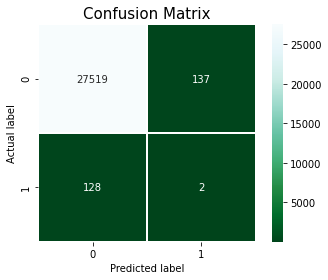

In [106]:
pretty_cm(y_pred, Y_test, [0, 1])

In [103]:
from sklearn import metrics


In [112]:
pd.DataFrame(df_Test).values

array([[-0.1586771 , -0.15772542,  0.31440033, ..., -0.02324074,
        -0.0355136 , -0.03448276],
       [-0.09945886,  0.1222537 ,  0.4049271 , ..., -0.02324074,
        -0.0355136 , -0.03448276],
       [-0.3738404 ,  1.7963373 , -0.42691076, ..., -0.02324074,
        -0.0355136 , -0.03448276],
       ...,
       [-0.37472426, -0.29972801,  0.85060634, ..., -0.02324074,
        -0.0355136 , -0.03448276],
       [ 0.58044612, -0.15106161,  0.95140742, ..., -0.02324074,
        -0.0355136 , -0.03448276],
       [-0.27970991, -1.29368663, -0.64467186, ..., -0.02324074,
        -0.0355136 , -0.03448276]])

In [113]:
anomalies_ratio = 0.005
if_eif = iso.iForest(df_Test, 
                     ntrees = 100, 
                     sample_size = 500, 
                     ExtensionLevel = 0)

# calculate anomaly scores
anomaly_scores = if_eif.compute_paths(X_in = df_Test)
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(.005* df_Test.shape[0])):]
# create predictions 
y_pred = np.zeros_like(Y_test)
y_pred[indices_with_preds] = 1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9903
Precision: 0.0000
Recall: 0.0000
F1: 0.0000


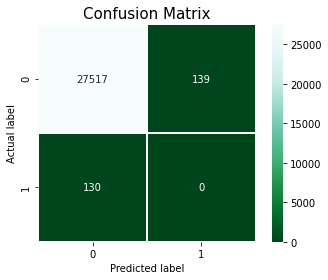

In [114]:
pretty_cm(y_pred, Y_test, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9910
Precision: 0.0647
Recall: 0.0692
F1: 0.0669
CPU times: user 12min 2s, sys: 20.6 s, total: 12min 23s
Wall time: 11min 50s


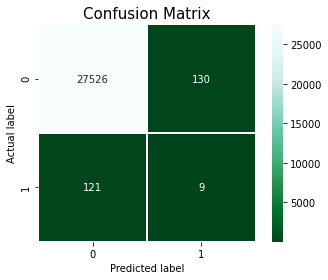

In [116]:
%%time
anomalies_ratio = 0.005
if_eif = iso.iForest(df_Test, 
                     ntrees = 100, 
                     sample_size = 500, 
                     ExtensionLevel = df_Test.shape[1] - 1)

# calculate anomaly scores
anomaly_scores = if_eif.compute_paths(X_in = df_Test)
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(.005* df_Test.shape[0])):]
# create predictions 
y_pred = np.zeros_like(Y_test)
y_pred[indices_with_preds] = 1
pretty_cm(y_pred, Y_test, [0, 1])